# 프로젝트 :  다양한 OCR모델 비교하기
## 🎯 루브릭 평가
1. OCR을 활용하여 구현하려는 서비스의 기획이 타당한지
2. 모델 평가기준이 명확하고 체계적인가
3. 평가기준에 따라 충분한 분량의 테스트가 진행되고 그 결과가 잘 정리되었는지

## OCR을 이용한 서비스 기획
* 영어와 숫자를 모두 탐지
* 다양한 형태의 이미지의 문자도 탐지

In [13]:
import os
import glob
import matplotlib.pyplot as plt
from PIL import Image

# 1. 검증용 데이터셋 준비

In [20]:
file_paths = glob.glob(os.getenv('HOME')+'/aiffel/ocr_python/image/*.*')
file_paths

['/aiffel/aiffel/ocr_python/image/ocr_sample6.png',
 '/aiffel/aiffel/ocr_python/image/ocr_sample8.jpeg',
 '/aiffel/aiffel/ocr_python/image/ocr_sample10.png',
 '/aiffel/aiffel/ocr_python/image/ocr_sample5.png',
 '/aiffel/aiffel/ocr_python/image/ocr_sample12.jpeg',
 '/aiffel/aiffel/ocr_python/image/ocr_sample2.png',
 '/aiffel/aiffel/ocr_python/image/ocr_sample9.webp',
 '/aiffel/aiffel/ocr_python/image/ocr_sample7.jpeg',
 '/aiffel/aiffel/ocr_python/image/ocr_sample3.jpeg',
 '/aiffel/aiffel/ocr_python/image/ocr_sample4.png',
 '/aiffel/aiffel/ocr_python/image/ocr_sample13.jpeg',
 '/aiffel/aiffel/ocr_python/image/ocr_sample11.jpeg',
 '/aiffel/aiffel/ocr_python/image/ocr_sample1.png']

# 2. Google OCR API, keras-ocr, Tesseract로 테스트 진행

## Google OCR API

In [21]:
#!pip install --upgrade google-cloud-vision

In [50]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  os.getenv('HOME')+'/aiffel/ocr_python/my_google_api_key.json'

In [53]:
from google.cloud import vision
import io
def detect_text(path):
    """Detects text in the file."""
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    result_text = []
    for text in texts:
        result_text.append(text.description)
        
    
    vertices = (['({},{})'.format(vertex.x, vertex.y)
                 for vertex in text.bounding_poly.vertices])

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))
        
    filename = os.path.basename(path)
    filename = filename.split('.')[0]

    text_path = os.getenv('HOME')+'/aiffel/ocr_python/image/google_result/'
    if not os.path.exists(text_path):
        os.mkdir(text_path)
    text_path = text_path+f'{filename}.txt'
    with open(text_path, 'w') as f:
        f.write(result_text[0])
    
    return result_text[0].replace('\n', ' ')+'\n'+'bounds: {}'.format(','.join(vertices))

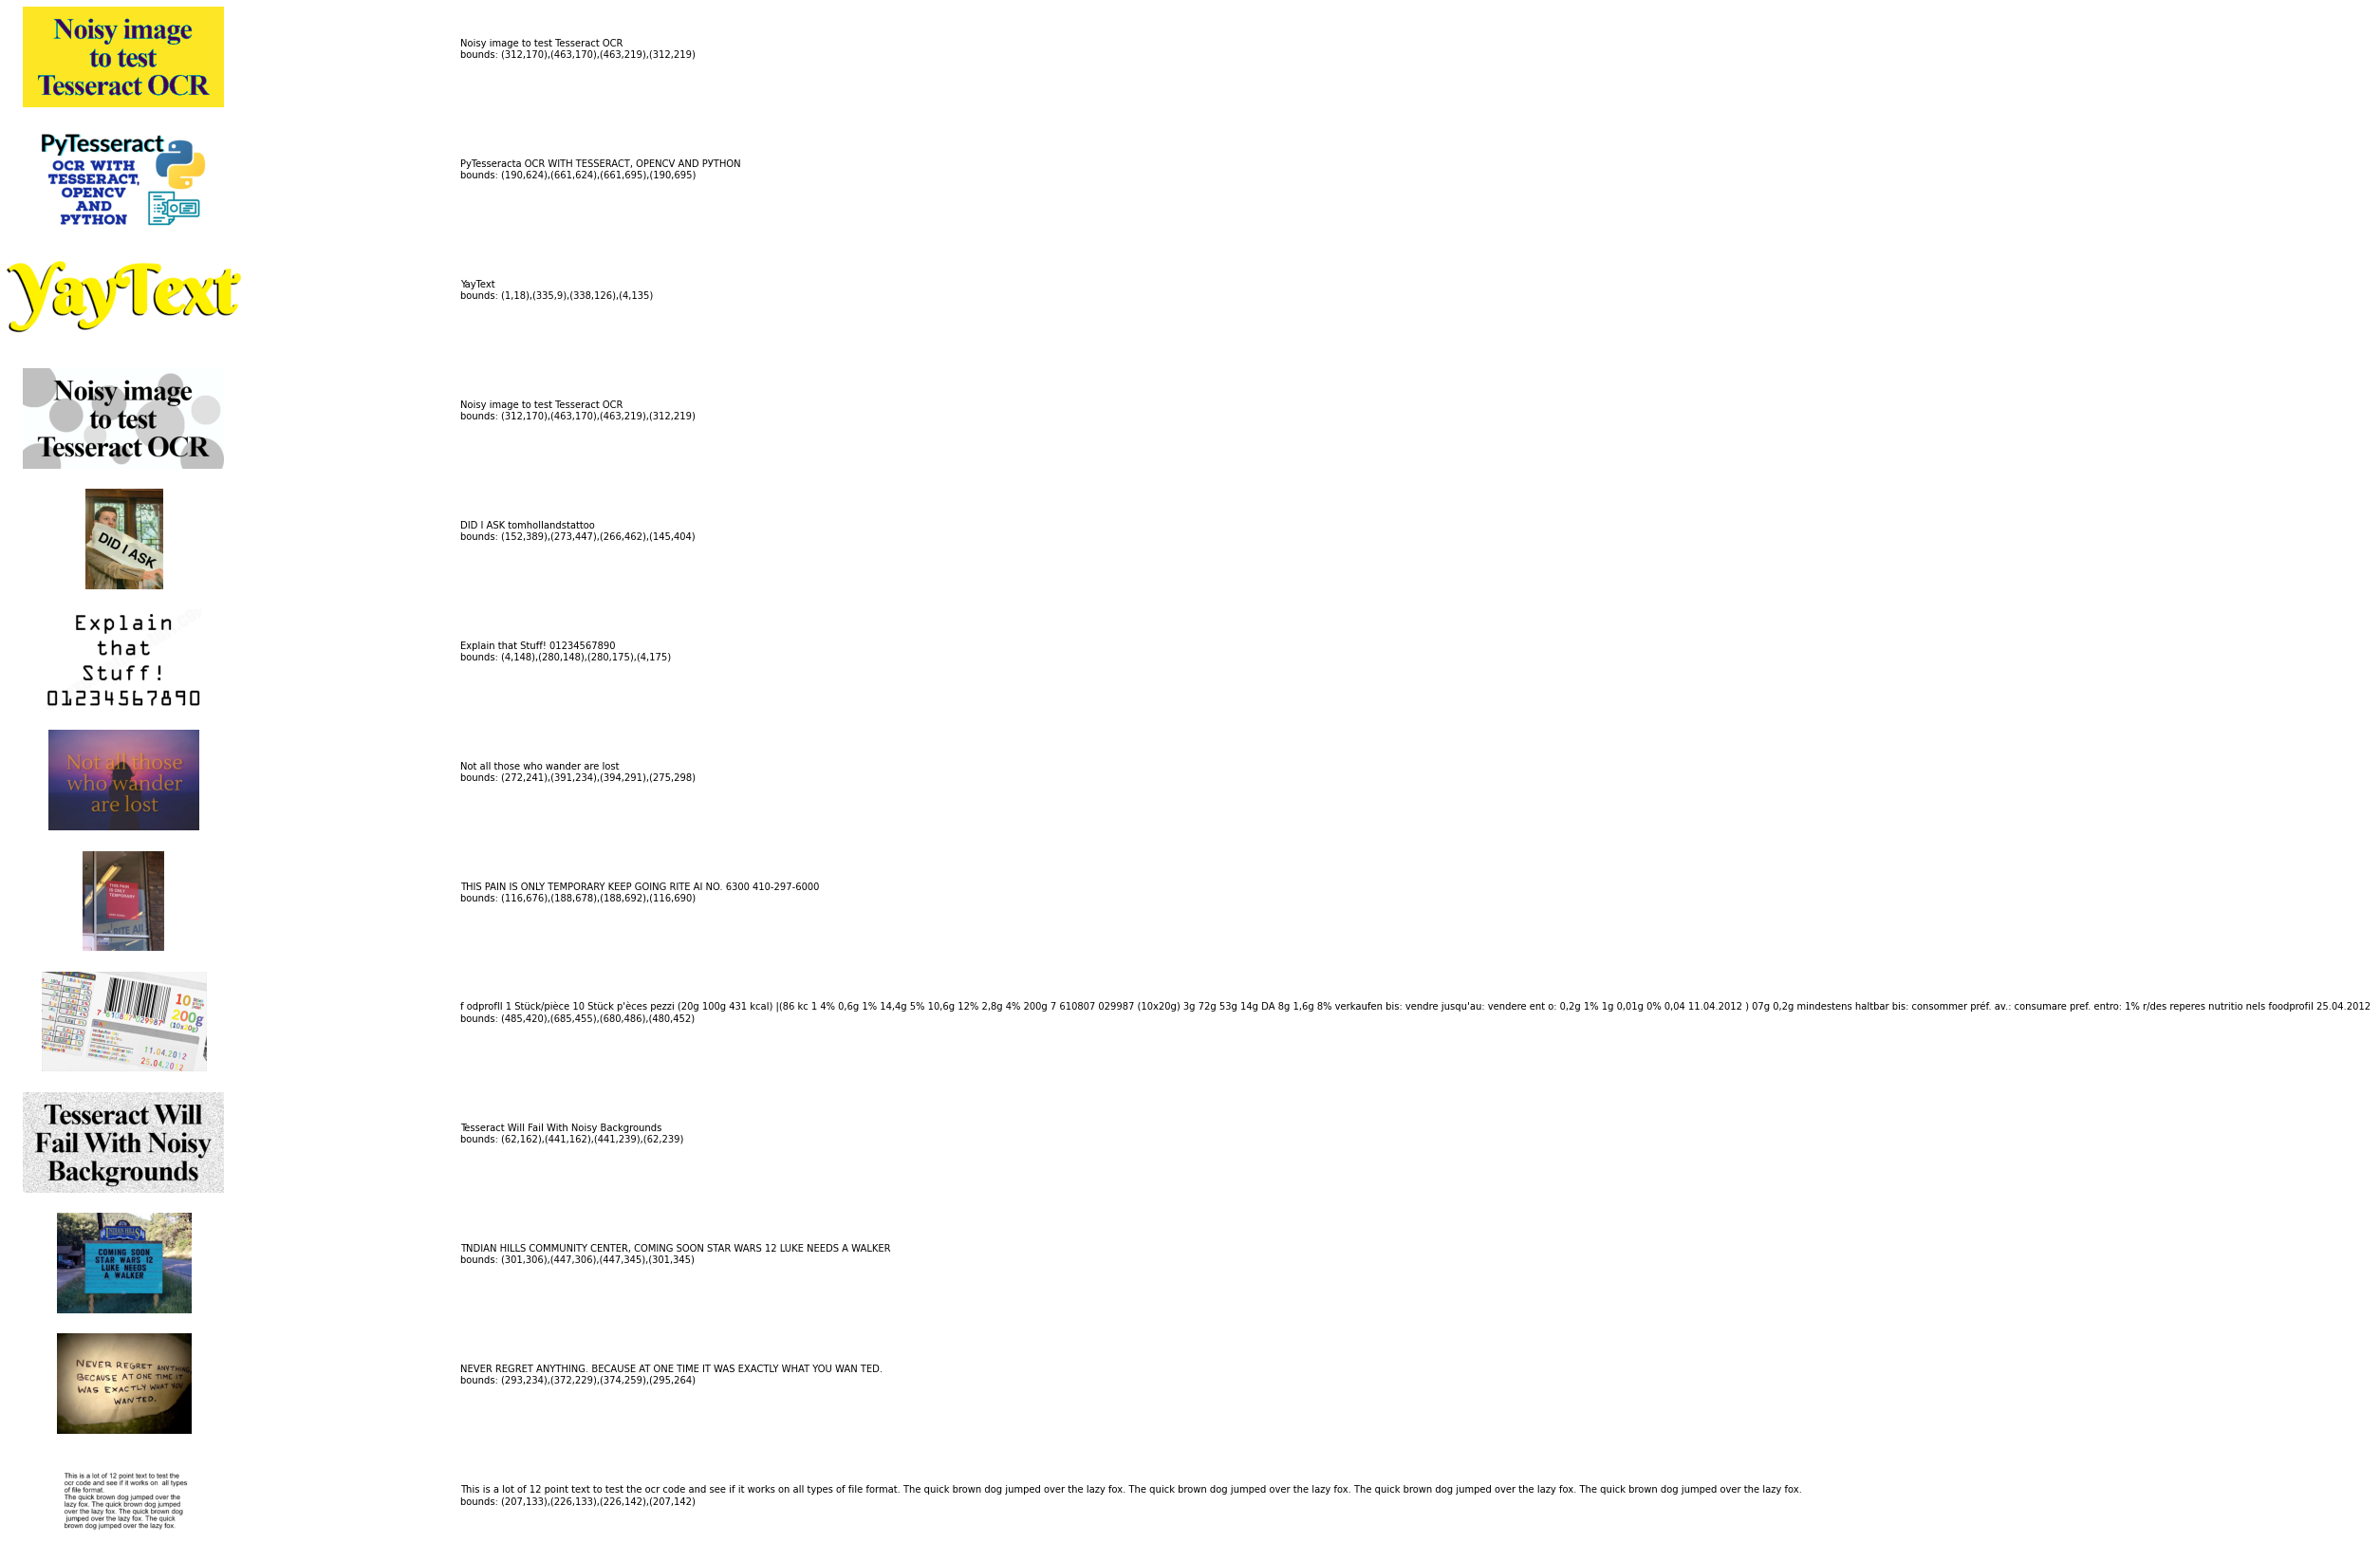

In [54]:
cols = 2
rows = len(file_paths)
fig, axs = plt.subplots(ncols=cols,nrows=rows, figsize=(20, 30))
idx = 0
for file_path in file_paths:
    image = Image.open(file_path)    
    axs[idx][0].imshow(image)
    axs[idx][1].text(x = 0, y = 0.5, s=detect_text(file_path), fontsize='medium')
    axs[idx][0].axis("off")
    axs[idx][1].axis("off")
    idx+=1
    

## keras_ocr

In [56]:
import matplotlib.pyplot as plt
import keras_ocr

# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


In [57]:
images = [keras_ocr.tools.read(url) for url in file_paths]
prediction_groups = [pipeline.recognize([url]) for url in file_paths]

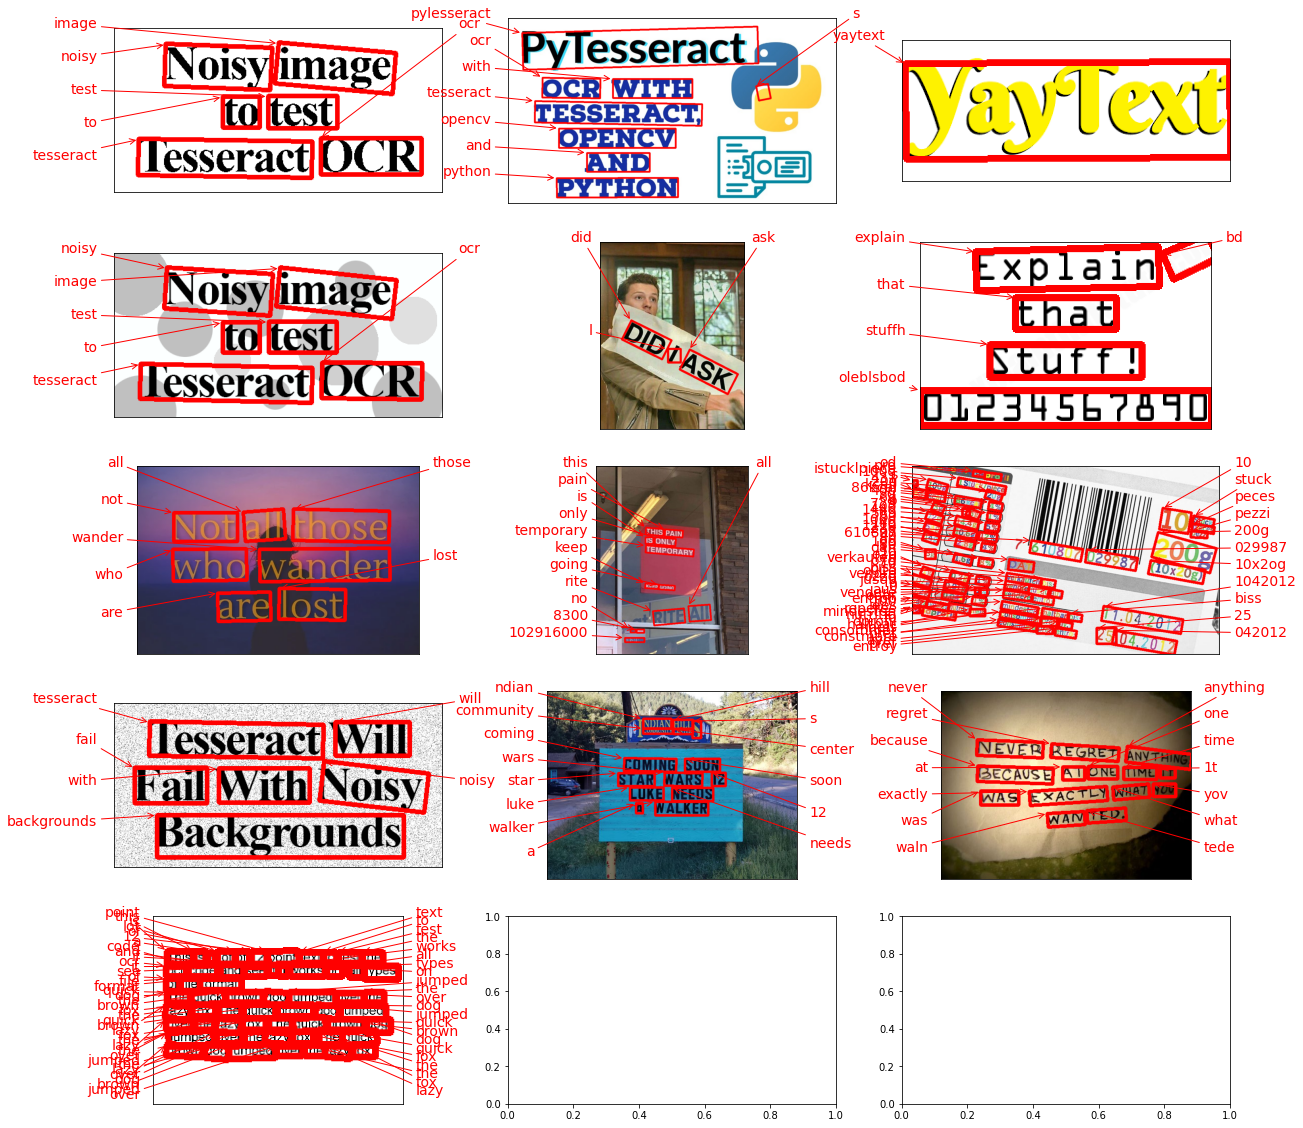

In [24]:
# Plot the predictions
cols = 3
rows = len(images)//cols + (len(images)%cols!=0)
fig, axs = plt.subplots(ncols=cols, nrows=rows, figsize=(20, 20))
for idx, ax in zip(range(len(images)), axs.flatten()):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

## Tesseract
### 문자 검출하고 이미지 자르기

In [79]:
!sudo apt install tesseract-ocr -y

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  liblept5 libopenjp2-7 libtesseract4 tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  liblept5 libopenjp2-7 libtesseract4 tesseract-ocr tesseract-ocr-eng
  tesseract-ocr-osd
0 upgraded, 6 newly installed, 0 to remove and 0 not upgraded.
Need to get 7,031 kB of archives.
After this operation, 22.0 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 libopenjp2-7 amd64 2.3.0-2build0.18.04.1 [145 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 liblept5 amd64 1.75.3-3 [929 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libtesseract4 amd64 4.00~git2288-10f4998a-2 [1,163 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:5 http://archive.ubuntu.c

In [80]:
!sudo apt install libtesseract-dev -y

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libleptonica-dev
The following NEW packages will be installed:
  libleptonica-dev libtesseract-dev
0 upgraded, 2 newly installed, 0 to remove and 0 not upgraded.
Need to get 2,755 kB of archives.
After this operation, 13.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libleptonica-dev amd64 1.75.3-3 [1,308 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libtesseract-dev amd64 4.00~git2288-10f4998a-2 [1,447 kB]
Fetched 2,755 kB in 1s (2,086 kB/s)         
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 2.)
debconf: falling back to frontend: Readline

78Selecting previously unselected package libleptonica-

In [81]:
def create_cropped_image_folder(image_path):
    filename = os.path.basename(image_path)
    image_path = image_path.replace(filename, '')
    filename = filename.split('.')[0]

    cropped_image_path = image_path+f'{filename}_cropped'
    if not os.path.exists(cropped_image_path):
        os.mkdir(cropped_image_path)
        
    return cropped_image_path
    

In [82]:
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.png'):
    output_path = create_cropped_image_folder(image_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list

In [83]:
work_dir = os.getenv('HOME')+'/aiffel/ocr_python/image'
cropped_image_path_list = []
for img_file_path in file_paths:
    cropped_image_path_list.append(crop_word_regions(img_file_path))


/aiffel/aiffel/ocr_python/image/ocr_sample6_cropped/0000.png
/aiffel/aiffel/ocr_python/image/ocr_sample6_cropped/0001.png
/aiffel/aiffel/ocr_python/image/ocr_sample6_cropped/0002.png
/aiffel/aiffel/ocr_python/image/ocr_sample6_cropped/0003.png
/aiffel/aiffel/ocr_python/image/ocr_sample6_cropped/0004.png
/aiffel/aiffel/ocr_python/image/ocr_sample6_cropped/0005.png
/aiffel/aiffel/ocr_python/image/ocr_sample8_cropped/0000.png
/aiffel/aiffel/ocr_python/image/ocr_sample8_cropped/0001.png
/aiffel/aiffel/ocr_python/image/ocr_sample8_cropped/0002.png
/aiffel/aiffel/ocr_python/image/ocr_sample8_cropped/0003.png
/aiffel/aiffel/ocr_python/image/ocr_sample8_cropped/0004.png
/aiffel/aiffel/ocr_python/image/ocr_sample8_cropped/0005.png
/aiffel/aiffel/ocr_python/image/ocr_sample8_cropped/0006.png
/aiffel/aiffel/ocr_python/image/ocr_sample8_cropped/0007.png
/aiffel/aiffel/ocr_python/image/ocr_sample8_cropped/0008.png
/aiffel/aiffel/ocr_python/image/ocr_sample8_cropped/0009.png
/aiffel/aiffel/ocr_pytho

In [84]:
def recognize_images(origin_image_path):
    filename = os.path.basename(origin_image_path)
    temp_path = origin_image_path.replace(filename, '')
    filename = filename.split('.')[0]
    
    cropped_image_path_list = glob.glob(temp_path+f'{filename}_cropped'+'/*')
    custom_oem_psm_config = r'--oem 3 --psm 7'
    recognized_text = []
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        recognized_text.append(recognized_data['text'])        
    return recognized_text

['fest\n\x0c', 'image\n\x0c', 'OCR\n\x0c', 'Noisy\n\x0c', 'to\n\x0c', 'Tesseract\n\x0c']
['OCR\n\x0c', '\x0c', 'LESSERACT,\n\x0c', 'PY THON\n\x0c', 'Pylessera\n\x0c', 'BIGEs|\n\x0c', 'a\n\x0c', 'AND\n\x0c', 'WiTeH\n\x0c', 'OPENCV\n\x0c']
['WS\n\x0c', 'Vay\n\x0c', 'L\n\x0c']
['besseract\n\x0c', '{oO\n\x0c', 'Noisy image\n\x0c', 'test\n\x0c', 'OCR\n\x0c']
['\x0c']
['PP SH Sb Pac\n\x0c', 'that\n\x0c', 'Fxplain\n\x0c', '\\Ntuft f !\n\x0c']
['exe\n\x0c', 'who wander\n\x0c', 'a cl\n\x0c', 'dre\n\x0c']
['ONLY\n\x0c', 'PAIN\n\x0c', 'alt\n\x0c', 'Ve\n\x0c', 'THIS\n\x0c', '\x0c', 'SS\n\x0c', 'Wie\n\x0c', 'TEMPORARY\n\x0c', ', |\n\x0c']
['(— &\n\x0c', 'USgu’ay.\n\x0c', '\x0c', 'Dre\n\x0c', 'CSten.\n\x0c', 'Nutrition ners\n\x0c', 'Dis:\n\x0c', '\x0c', "'EDeres\n\x0c", 'NtrQ:\n\x0c', 'laltbar\n\x0c', '“Onsomme,\n\x0c', '/des\n\x0c', 'Profi\n\x0c', '\x0c', 'ro.\n\x0c', 'Mind\n\x0c']
['Fail\n\x0c', 'Tesseract\n\x0c', 'Noisy\n\x0c', '\x0c', '\x0c', 'Will\n\x0c', 'Backgrounds\n\x0c', 'With\n\x0c', '\x0

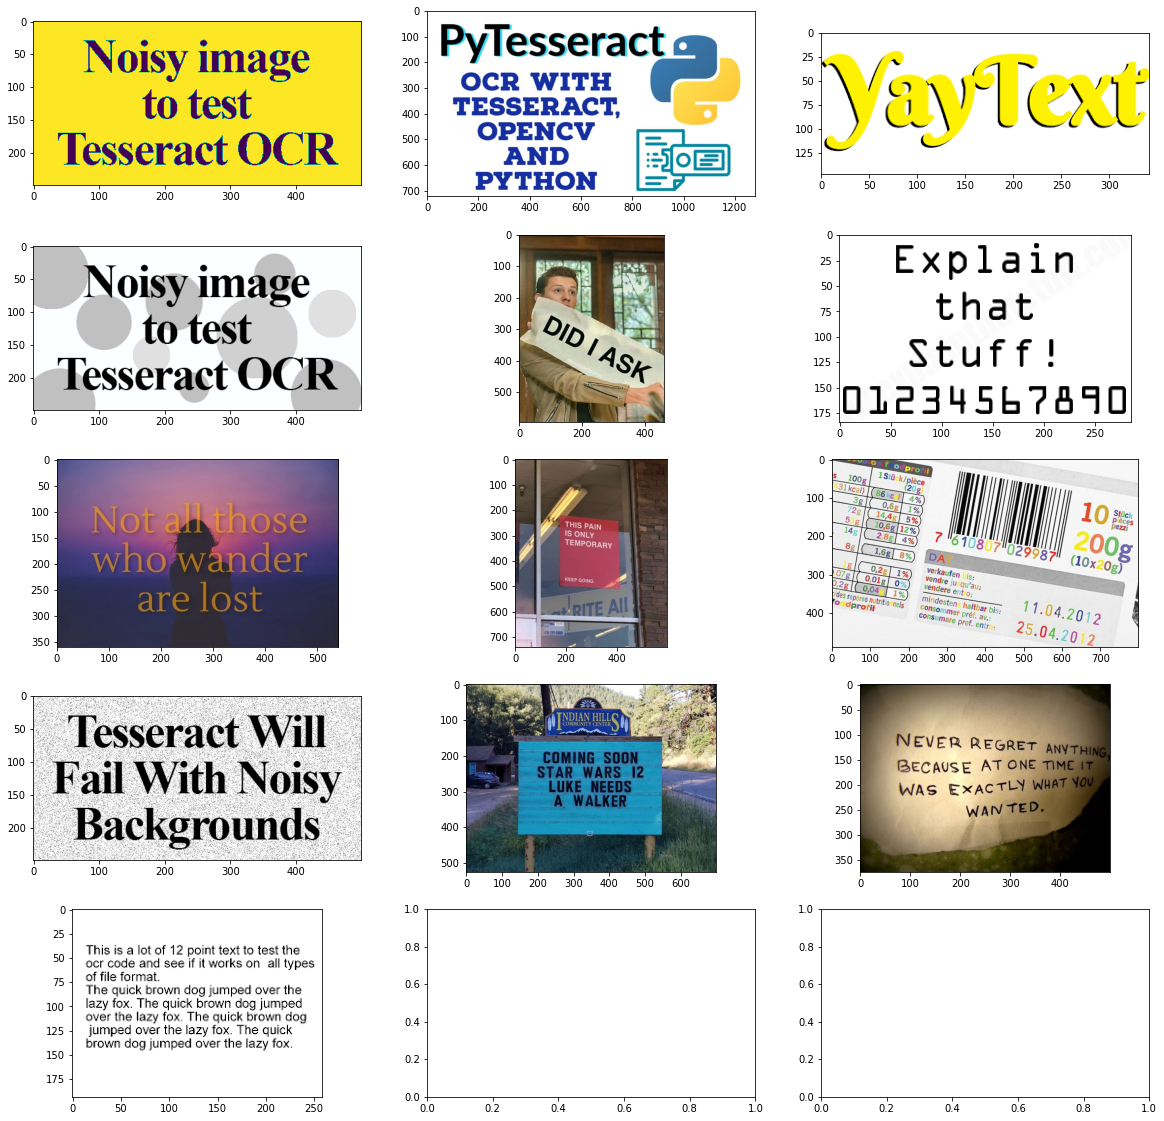

In [103]:
cols = 3
rows = len(file_paths)//cols + (len(file_paths)%cols!=0)
fig, axs = plt.subplots(ncols=cols, nrows=rows, figsize=(20, 20))
for file_path, ax in zip(file_paths, axs.flatten()):
    image = Image.open(file_path)
    ax.imshow(image)    
    print(recognize_images(file_path))
    

# 3. 테스트 결과 정리

동일한 이미지에 대해서 각각 어떤 결과를 내는지 한번에 시각화를 해보았다.

In [59]:
one_image_path = '/aiffel/aiffel/ocr_python/image/ocr_sample2.png'

In [71]:
one_images = keras_ocr.tools.read(one_image_path)
one_prediction_groups = pipeline.recognize([one_image_path])

/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


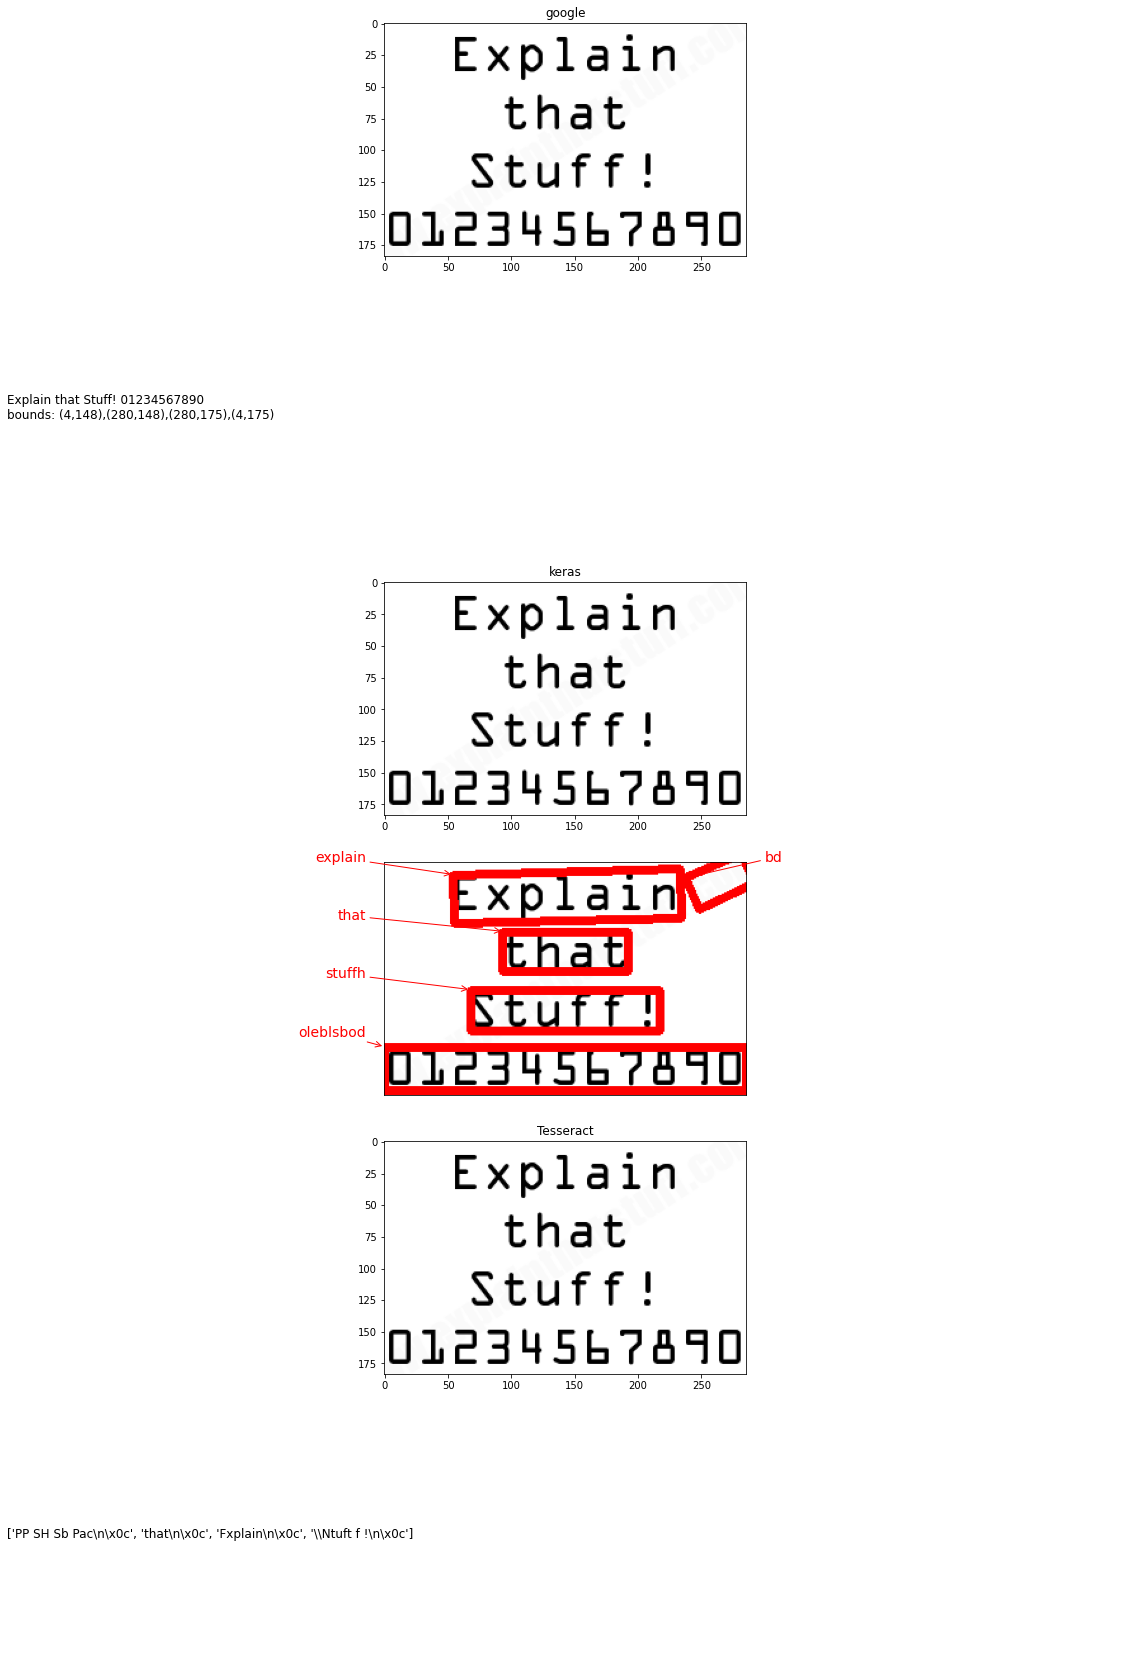

In [86]:
fig, axs = plt.subplots(nrows=6, figsize=(20, 30))
titles = ['google', 'keras', 'Tesseract']
for idx, ax in enumerate(axs.flatten()):
    if idx % 2 == 0:
        image = Image.open(one_image_path)
        ax.imshow(image)
        ax.set_title(titles[idx // 2])

axs[1].text(x = 0, y = 0.5, s=detect_text(one_image_path), fontsize='large')
axs[1].axis("off")

keras_ocr.tools.drawAnnotations(image=one_images, 
                                    predictions=one_prediction_groups[0], ax=axs[3])

axs[5].text(x = 0, y = 0.5, s=recognize_images(one_image_path), fontsize='large')
axs[5].axis("off")

plt.show()

# 4. 결과 분석과 결론 제시

결과를 분석한 결과 숫자까지 제대로 인식한 것은 **Google OCR API** 였다.    
테스트 한것을 살펴보면 keras_ocr도 숫자를 인식하는 것이 있었지만 인식을 못하는 것도 있었고, 비어있는 배경을 문자로 인식하기도 했다.

따라서 다양한 형태의 이미지에서 숫자와 영어 둘다 인식하기에는 Google OCR API가 적절해보인다.

# 회고

## 아쉬운 점
* 수치적으로 정확한 평가방법이 있었을 것 같은데 그것을 도입하지 못했다.
* 나름 다양한 사진을 골랐다고 생각했는데 비슷한 이미지가 많았던 것 같다.
* 평가 기준을 명확하고 체계적으로 진행한 것이 아니라 시각적인 것에 많이 의지한 방법이었다.


## 느낀점
* 어떤 프로세스로 모델을 선택하는지 배웠다. 해커톤을 진행할 때도 모델 선정을 할 때 기획의 목적과 평가 전략을 세워서 해야겠다고 느꼈다.
* 제공하는 모델이 많은 것을 느꼈고, 문제를 해결하려고 할 때 이미 사전 학습된 모델을 찾아서 하는 것이 성능 향상에 도움이 될 것이라 느꼈다.

# Reference
* https://deview.kr/data/deview/2019/presentation/[123]%EB%AC%B8%EC%9E%90%EC%9D%B8%EC%8B%9D(OCR),+%EC%96%BC%EB%A7%88%EB%82%98+%EC%A0%95%ED%99%95%ED%95%98%EC%A7%80+(%EB%AC%B8%EC%9E%90%EC%9D%B8%EC%8B%9D+%EC%84%B1%EB%8A%A5%EC%9D%84+%EC%A0%95%ED%99%95%ED%95%98%EA%B2%8C+%EC%B8%A1%EC%A0%95%ED%95%98%EB%8A%94+%EB%B0%A9%EB%B2%95).pdf
* https://jakevdp.github.io/mpl_tutorial/tutorial_pages/tut4.html